In [1]:
import sympy as sym
import pandas as pd
from math import ceil, floor, log2
import enum

In [2]:
class CoeffType(enum.Enum):
    Type1Pad = 1
    Type2 = 2
    Type3Pad = 3
    Type4 = 4
    NonLinPhase = 5
    HalfBand = 6

def hffa(p, ws):
    if p==1:
        return [ws]
    return hffa(p//2, ws[0::2]) + \
           hffa(p//2, [a+b for (a,b) in zip(ws[0::2],ws[1::2])]) + \
           hffa(p//2, ws[1::2])

def hpoly(p, ws):
    return [ws for _ in range(p)]

def eqTerms(x, y):
    return 0 == sym.simplify(x-y)

# NOTE: We aren't checking if one term is a bitshifted version of an existing one... can we prove this will not happen?
def uniqAbsTerms(xs):
    uniqs = []
    for x in xs:
        if not ( any([eqTerms(sym.Abs(x),u) for u in uniqs]) or \
                 eqTerms(x,0) ):
            uniqs.append(sym.Abs(x))
    return uniqs

def countMults(h):
    return sum([len(ws) for ws in h])

_nonlinPhase = lambda n : [sym.Symbol('w'+str(i)) for i in range(n)]

_type2 = lambda n : [sym.Symbol('w'+str(i)) for i in range(n//2)] + \
                    [sym.Symbol('w'+str(i)) for i in range(n//2-1,-1,-1)]

_type4 = lambda n : [sym.Symbol('w'+str(i)) for i in range(n//2)] + \
                    [(-1)*sym.Symbol('w'+str(i)) for i in range(n//2-1,-1,-1)]

_type1Padded = lambda n : [sym.Symbol('w'+str(i)) for i in range(n//2 - 1)] + \
                          [sym.Symbol('w'+str(n//2-1))] + \
                          [sym.Symbol('w'+str(i)) for i in range(n//2-1-1,-1,-1)] + \
                          [0]

_type3Padded = lambda n : [sym.Symbol('w'+str(i)) for i in range(n//2 - 1)] + \
                          [sym.Symbol('w'+str(n//2-1))] + \
                          [(-1)*sym.Symbol('w'+str(i)) for i in range(n//2-1-1,-1,-1)] + \
                          [0]

def _halfBand(n):
    if n == 2:
        return [0,0]
    ws = [0 for _ in range(n)]
    if n//2 % 2 == 1:
        ws[::2] = _type1Padded(n//2+1)[:-1]
    else:
        ws[::2] = _type1Padded(n//2)
    return ws

def genCoeffs(coeffType, n):
    if coeffType == CoeffType.Type1Pad:
        return _type1Padded(n)
    if coeffType == CoeffType.Type2:
        return _type2(n)
    if coeffType == CoeffType.Type3Pad:
        return _type3Padded(n)
    if coeffType == CoeffType.Type4:
        return _type4(n)
    if coeffType == CoeffType.NonLinPhase:
        return _nonlinPhase(n)
    if coeffType == CoeffType.HalfBand:
        return _halfBand(n)

In [73]:
frame = pd.DataFrame(columns=['FIR', 'CoeffType', 'Parallelism', 'N', 'SubfiltN', 'Mults'])

def ffa_hnlp(par, n):
    p = int(log2(par))
    return n*3**(p)

def ffa_htype2(par, n):
    p = int(log2(par))
    return ceil(n/2.0)+2*n*sum([3**i for i in range(0,p)])

def ffa_htype4(par, n):
    p = int(log2(par))
    return floor(n/2.0)+2*n*sum([3**i for i in range(0,p)])

def ffa_htype1(par, n):
    p = int(log2(par))
    return 2*n + n*sum([3**k for k in range(1,p)]) + (p-1)*(ceil(n/2.0))+2*n*sum([sum ([3**i for j in range(0,i-1)]) for i in range(0,p-2)])

for p in [2,4,8,16]:
    print(f'Running p{p}')
    for nByP in [1,2,3,4]:
        print(f'Running nByP{nByP}')
        for coeffType in [CoeffType.Type1Pad]:
            ws = genCoeffs(coeffType, p*nByP)
            mults = countMults([uniqAbsTerms(h) for h in hffa(p, ws)])
            frame = frame.append(dict(FIR='FFA', CoeffType=coeffType.name, Parallelism=p, N=(p*nByP), SubfiltN=nByP, Mults=mults), ignore_index=True)
            
            frame = frame.append(dict(FIR='Guess', CoeffType=coeffType.name, Parallelism=p, N=(p*nByP), SubfiltN=nByP, Mults=ffa_htype1(p,nByP), MultsPerChannel=guess(p,nByP)/p), ignore_index=True)

Running p2
Running nByP1
Running nByP2
Running nByP3
Running nByP4
Running p4
Running nByP1
Running nByP2
Running nByP3
Running nByP4
Running p8
Running nByP1
Running nByP2
Running nByP3
Running nByP4
Running p16
Running nByP1
Running nByP2
Running nByP3
Running nByP4


In [74]:
frame

,FIR,CoeffType,Parallelism,N,SubfiltN,Mults,MultsPerChannel
0,FFA,Type1Pad,2,2,1,2,NaN
1,Guess,Type1Pad,2,2,1,2,1.0000
2,FFA,Type1Pad,2,4,2,4,NaN
3,Guess,Type1Pad,2,4,2,4,2.5000
4,FFA,Type1Pad,2,6,3,6,NaN
5,Guess,Type1Pad,2,6,3,6,3.5000
6,FFA,Type1Pad,2,8,4,8,NaN
7,Guess,Type1Pad,2,8,4,8,5.0000
8,FFA,Type1Pad,4,4,1,8,NaN
9,Guess,Type1Pad,4,4,1,6,2.0000


3
5
7
9
8
12
17
21
29
47
67
85
110
190
273
353


In [8]:
frame = pd.DataFrame(columns=['FIR', 'CoeffType', 'Parallelism', 'N', 'SubfiltN', 'Mults'])

for p in [2,4,8,16]:
    print(f'Running p{p}')
    for nByP in [1,2,3,4]:
        print(f'Running nByP{nByP}')
        for coeffType in CoeffType:
            ws = genCoeffs(coeffType, p*nByP)
            mults = countMults([uniqAbsTerms(h) for h in hffa(p, ws)])
            frame = frame.append(dict(FIR='FFA', CoeffType=coeffType.name, Parallelism=p, N=(p*nByP), SubfiltN=nByP, Mults=mults), ignore_index=True)
            
            mults = countMults([uniqAbsTerms(h) for h in hpoly(p, ws)])
            frame = frame.append(dict(FIR='Poly', CoeffType=coeffType.name, Parallelism=p, N=(p*nByP), SubfiltN=nByP, Mults=mults, MultsPerChannel=mults/p), ignore_index=True)

Running p2
Running nByP1
Running nByP2
Running nByP3
Running nByP4
Running p4
Running nByP1
Running nByP2
Running nByP3
Running nByP4


KeyboardInterrupt: 

In [4]:
frame.to_cpd.read_csv("data.csv")sv('outputs/coeffSyms.csv', index = False, header=True)

In [3]:
frame = pd.read_csv("outputs/coeffSyms.csv")

In [45]:
in_frame[in_frame['FIR']=='FFA'][in_frame['CoeffType'] != 'Type1Pad'][in_frame['CoeffType'] != 'Type3Pad'][in_frame['CoeffType'] != 'NonLinPhase'][in_frame['CoeffType'] != 'HalfBand']

<ipython-input-45-4f4599e2da2d>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,FIR,CoeffType,Parallelism,N,SubfiltN,Mults,MultsPerChannel
2,FFA,Type2,2,2,1,3,NaN
6,FFA,Type4,2,2,1,3,NaN
14,FFA,Type2,2,4,2,5,NaN
18,FFA,Type4,2,4,2,5,NaN
26,FFA,Type2,2,6,3,8,NaN
30,FFA,Type4,2,6,3,7,NaN
38,FFA,Type2,2,8,4,10,NaN
42,FFA,Type4,2,8,4,10,NaN
50,FFA,Type2,4,4,1,9,NaN
54,FFA,Type4,4,4,1,9,NaN


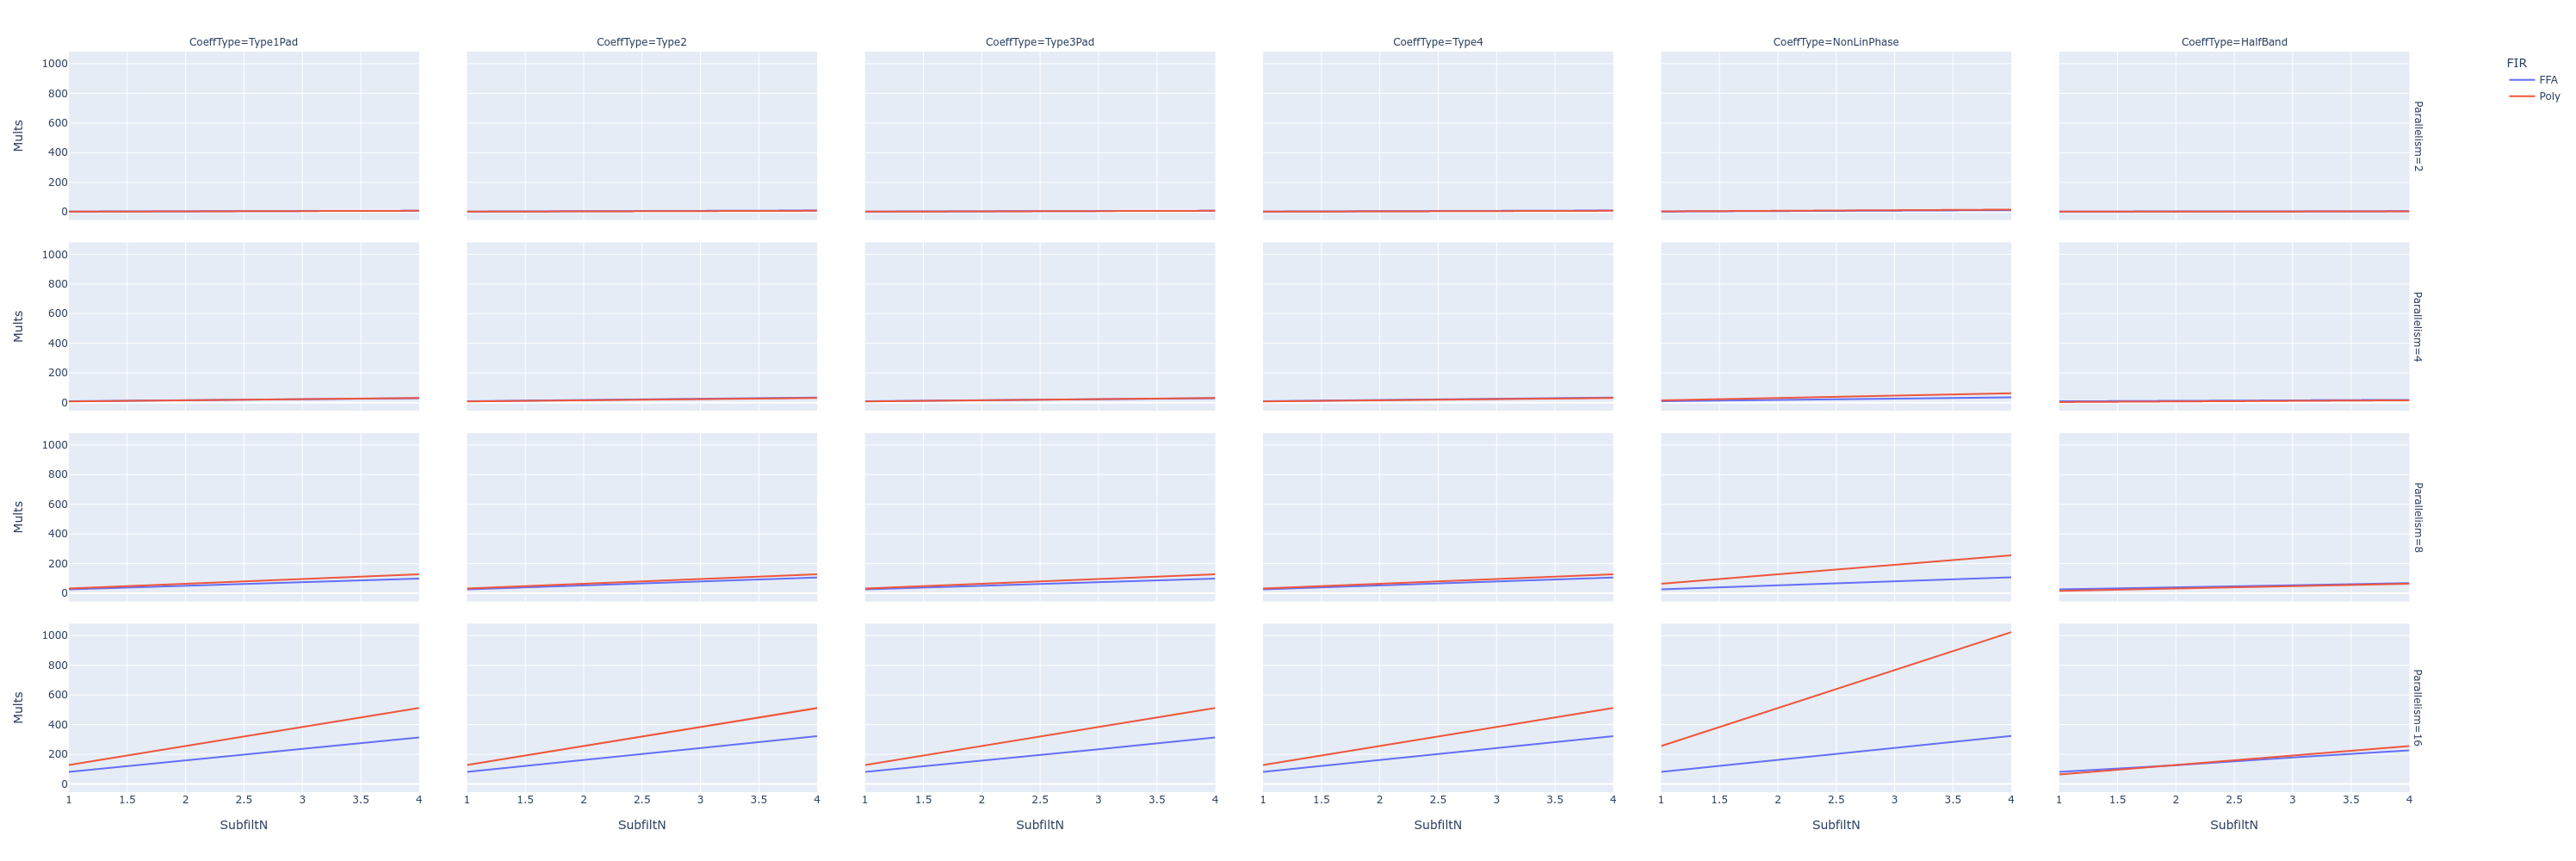

In [6]:
import plotly.express as px
px.line(frame, x='SubfiltN',y='Mults', color='FIR', facet_row='Parallelism', facet_col='CoeffType', height=1000)